In [38]:
randomUserComment1 = """
I tried it out. It's impressive, but it is still quite a bit behind GPT4-v and GPT4o. And it still cannot identify the resolution of an image, whereas ChatGPT can which means the model is not capable of any spatial aware tasks like object detection and bounding box calculation
"""

In [39]:
randomUserComment2 = """when we prompt Molmo to, for example, "detect people", it returns a response providing the x, y coordinates of each object, normalized to floats within the range of 0 to 100.

we can parse these coordinates and then use them as a prompt for SAM2.

exploring Molmo + SAM2 combo

Molmo - detect and extract object xy coordinates
SAM2 - convert xy coordinates into masks

TL;DR: combo works; but:
- Molmo may struggle to detect all objects in crowded scenes
- SAM2 may generate low-quality masks when prompted with points"""


# Molmo 1B Python

https://huggingface.co/allenai/MolmoE-1B-0924

1. **Processor Invocation**
   - **Before**: Called `processor` directly like a function.
   - **After**: Used `processor.process()` method.
   - **Why**: `processor` is not callable; correct method is `process()`.

2. **Handling Pixel Values**
   - **Before**: Tried to access `pixel_values`, which didn’t exist.
   - **After**: Moved all inputs to the model's device using `.to(model.device)`.
   - **Why**: The model doesn’t return `pixel_values`.

3. **Text Generation Method**
   - **Before**: Used `generate()` method.
   - **After**: Switched to `generate_from_batch()`.
   - **Why**: This model requires `generate_from_batch()` for multimodal input.

4. **Input Batching**
   - **Before**: Inputs had no explicit batch handling.
   - **After**: Added `.unsqueeze(0)` to create a batch of size 1.
   - **Why**: Model expects inputs to be batched.

5. **Generation Configuration**
   - **Before**: No generation configuration specified.
   - **After**: Added `GenerationConfig` to set max tokens and stop conditions.
   - **Why**: Needed to control generation behavior.

6. **Extracting Generated Tokens**
   - **Before**: Didn’t handle token extraction properly.
   - **After**: Extracted new tokens and decoded them.
   - **Why**: Needed to separate generated tokens from input tokens.


In [1]:
# !pip install einops torchvision

In [2]:
# !pip install safetensors

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import requests
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

# Define model ID
model_id = "allenai/MolmoE-1B-0924"

# Load processor
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto"
)

# Load the model, forcing it to run on CPU
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto",
    device_map=None  # Ensure no offloading happens and the model runs on CPU
)

# Fetch and process the image
image_url = "https://picsum.photos/id/237/536/354"
image = Image.open(requests.get(image_url, stream=True).raw)

# Process the image and text using the processor's `process` method
inputs = processor.process(
    images=[image],
    text="Describe this image.",
)

# Move inputs to the correct device and ensure the batch size is 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# Generate output using `generate_from_batch`
generation_config = GenerationConfig(max_new_tokens=100, stop_strings=["<|endoftext|>"])
output = model.generate_from_batch(
    inputs,
    generation_config=generation_config,
    tokenizer=processor.tokenizer
)

# Extract the generated tokens and decode them to text
generated_tokens = output[0, inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

# Print the generated text
print(generated_text)


## Description of the warnings

Message: oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders.

Meaning: This message informs you that TensorFlow is using oneDNN (Deep Neural Network Library) custom operations to improve performance. Minor differences in floating-point calculations could occur because of optimizations. You can disable these by setting TF_ENABLE_ONEDNN_OPTS=0.

Message: Unable to register cuFFT factory

Meaning: The CUDA-related libraries (cuFFT, cuDNN, and cuBLAS) are trying to register twice in the system, which is not allowed. It typically occurs if the libraries are already loaded or initialized by another part of the code. Since you're running on a CPU and not using CUDA, you can ignore these errors, as they don’t impact the functionality.

Message: This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

Meaning: This message indicates that TensorFlow is optimized to use CPU instructions like AVX2, AVX_VNNI, and FMA for performance. It suggests that further optimizations can be enabled by rebuilding TensorFlow with specific compiler flags, but this is not necessary for basic functionality.

message: The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization.

meaning: this warning indicates that the model checkpoint is using a different tokenizer (GPTNeoXTokenizer) than expected (Qwen2TokenizerFast). It may result in incorrect tokenization, but in this case, it worked correctly. You may want to ensure that the tokenizer class is consistent with the model to avoid potential issues in future runs.

# Molmo 7B-D Python

(the better of the two)

Example of its use : https://molmo.allenai.org/ 

https://huggingface.co/allenai/Molmo-7B-D-0924

took 13 minutes to the 1 for the 7b model the first time I used it when asking for a descriptioin( a lot of models were previously ran)

took 6 minutes the second time when asking for a descriptioin ( first model ran once computer turned on ) (twice now)

Asking for coordinates can take anywhere from 2-5 minutes. 

As it stands, JPG images work great. I hit a snag with PNG's but not sure if that's the model or me.

### Load the model

In [1]:
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

# Define model ID
model_id = "allenai/Molmo-7B-D-0924"

# Load processor
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto"
)

# Load the model, forcing it to run on CPU
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto",
    device_map=None  # Ensure no offloading happens and the model runs on CPU
)

2024-09-29 13:20:59.707124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 13:20:59.873681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Run the model

In [2]:
# Fetch and process the image
image_url = "https://picsum.photos/id/237/536/354"
image = Image.open(requests.get(image_url, stream=True).raw)

image_path = "/home/carlos/Documents/GitHub/aiexp/coconutladenswallow.jpg"
image = Image.open(image_path)

# Process the image and text using the processor's `process` method
inputs = processor.process(
    images=[image],
    text="User: point to me the coconutladenswallow Assistant:",
    stream="true"
)

# Move inputs to the correct device and ensure the batch size is 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# Generate output using `generate_from_batch`
generation_config = GenerationConfig(max_new_tokens=100, stop_strings=["<|endoftext|>"])
output = model.generate_from_batch(
    inputs,
    generation_config=generation_config,
    tokenizer=processor.tokenizer
)

# Extract the generated tokens and decode them to text
generated_tokens = output[0, inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

# Print the generated text
print(generated_text)



 <point x="42.0" y="27.0" alt="me the coconutladenswallow">me the coconutladenswallow</point>


Took two minutes to run (twice now) and returned 

`<point x="26.0" y="51.5" alt="nose">nose</point>`

` <point x="42.0" y="27.0" alt="me the coconutladenswallow">me the coconutladenswallow</point>`

### Display the result

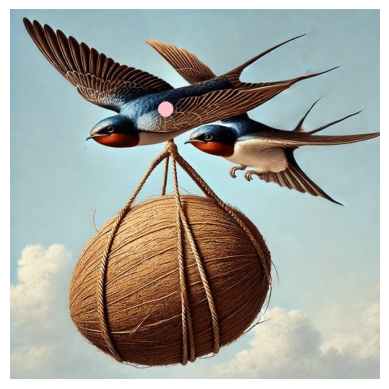

In [5]:
# Check if the tag is a single point or multiple points
if '<point' in generated_text:
    # Handle single point case
    match = re.search(r'<point x="([\d.]+)" y="([\d.]+)" alt=".*?">.*?</point>', generated_text)
    if match:
        points = [(float(match.group(1)), float(match.group(2)))]
elif '<points' in generated_text:
    # Handle multiple points case
    match = re.findall(r'x\d+="([\d.]+)"\s+y\d+="([\d.]+)"', generated_text)
    if match:
        points = [(float(x), float(y)) for x, y in match]

# Convert relative coordinates (percentage) to absolute pixel values
image_width, image_height = image.size
absolute_points = [(int(x / 100 * image_width), int(y / 100 * image_height)) for x, y in points]

# Draw pink circles at the extracted coordinates
draw = ImageDraw.Draw(image)
circle_radius = 10
for x_abs, y_abs in absolute_points:
    circle_bbox = [x_abs - circle_radius, y_abs - circle_radius, x_abs + circle_radius, y_abs + circle_radius]
    draw.ellipse(circle_bbox, outline="pink", width=3, fill="pink")

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# Basically the same thing as above just broken down a littttttttttttttttle more for testing.

In [10]:
import requests
from PIL import Image, ImageDraw
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
import re
import matplotlib.pyplot as plt

In [11]:
# Fetch and process the image
image_url = "https://picsum.photos/id/237/536/354"
image = Image.open(requests.get(image_url, stream=True).raw)

image_path = "/home/carlos/Documents/GitHub/aiexp/coconutladenswallow.jpg" # mee2.jpg
image = Image.open(image_path)

userMessage = "point to me the coconutladenswallow"


In [12]:
# Define model ID
model_id = "allenai/Molmo-7B-D-0924"

# Load processor
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto"
)

# Load the model, forcing it to run on CPU
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype="auto",
    device_map=None  # Ensure no offloading happens and the model runs on CPU
)

# Process the image and text using the processor's `process` method
inputs = processor.process(
    images=[image],
    text="User: " + userMessage + " Assistant:",
    stream="true"
)

# Move inputs to the correct device and ensure the batch size is 1
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

# Generate output using `generate_from_batch`
generation_config = GenerationConfig(max_new_tokens=100, stop_strings=["<|endoftext|>"])
output = model.generate_from_batch(
    inputs,
    generation_config=generation_config,
    tokenizer=processor.tokenizer
)

# Extract the generated tokens and decode them to text
generated_tokens = output[0, inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

# Print the generated text
print("Generated output:", generated_text)

# Now process the generated point and draw a pink circle on the image
# The generated point from the model
generated_point = generated_text  # Use the output from the model, expected in the format of a <point> tag

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Generated output:  <point x="42.0" y="27.0" alt="me the coconutladenswallow">me the coconutladenswallow</point>


`<point x="38.5" y="75.9" alt="DoB">DoB</point>`

`<points x1="23.0" y1="45.0" x2="28.6" y2="44.8" x3="70.2" y3="22.0" x4="73.5" y4="21.8" alt="eyes">eyes</points>`

In [13]:
print(generated_point)

 <point x="42.0" y="27.0" alt="me the coconutladenswallow">me the coconutladenswallow</point>


In [14]:
image_path = "/home/carlos/Documents/GitHub/aiexp/coconutladenswallow.jpg"
image = Image.open(image_path)

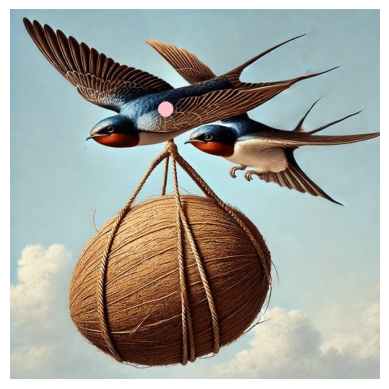

In [15]:
# Check if the tag is a single point or multiple points
if '<point' in generated_point:
    # Handle single point case
    match = re.search(r'<point x="([\d.]+)" y="([\d.]+)" alt=".*?">.*?</point>', generated_point)
    if match:
        points = [(float(match.group(1)), float(match.group(2)))]
elif '<points' in generated_point:
    # Handle multiple points case
    match = re.findall(r'x\d+="([\d.]+)"\s+y\d+="([\d.]+)"', generated_point)
    if match:
        points = [(float(x), float(y)) for x, y in match]

# Convert relative coordinates (percentage) to absolute pixel values
image_width, image_height = image.size
absolute_points = [(int(x / 100 * image_width), int(y / 100 * image_height)) for x, y in points]

# Draw pink circles at the extracted coordinates
draw = ImageDraw.Draw(image)
circle_radius = 10
for x_abs, y_abs in absolute_points:
    circle_bbox = [x_abs - circle_radius, y_abs - circle_radius, x_abs + circle_radius, y_abs + circle_radius]
    draw.ellipse(circle_bbox, outline="pink", width=3, fill="pink")

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# Trouble Shooting

## FAQs

I'm getting an error a broadcast error when processing images!
Your image might not be in RGB format. You can convert it using the following code snippet:

        ```
        from PIL import Image

        image = Image.open(...)

        if image.mode != "RGB":
            image = image.convert("RGB")
        ```
        
Molmo doesn't work great with transparent images!
We received reports that Molmo models might struggle with transparent images. For the time being, we recommend adding a white or dark background to your images before passing them to the model. The code snippet below shows how to do this using the Python Imaging Library (PIL):

        ```
        # Load the image
        url = "..."
        image = Image.open(requests.get(url, stream=True).raw)

        # Convert the image to grayscale to calculate brightness
        gray_image = image.convert('L')  # Convert to grayscale

        # Calculate the average brightness
        stat = ImageStat.Stat(gray_image)
        average_brightness = stat.mean[0]  # Get the average value

        # Define background color based on brightness (threshold can be adjusted)
        bg_color = (0, 0, 0) if average_brightness > 127 else (255, 255, 255)

        # Create a new image with the same size as the original, filled with the background color
        new_image = Image.new('RGB', image.size, bg_color)

        # Paste the original image on top of the background (use image as a mask if needed)
        new_image.paste(image, (0, 0), image if image.mode == 'RGBA' else None)

        # Now you can pass the new_image to Molmo
        processor = AutoProcessor.from_pretrained(
            'allenai/Molmo-7B-D-0924',
            trust_remote_code=True,
            torch_dtype='auto',
            device_map='auto'
        )
        ```